In this script, we train model with four supervised algorithms and select the best model type for this prediction 


In [ ]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
import joblib
import json
from pycaret.classification import *


In [ ]:
%reload_ext autoreload

import Utility as fn



In [204]:
# read processed diabetes data
diabetic_data = pd.read_csv('diabetic_df_processed.csv')

diabetic_data

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,...,insulin_3,glyburide-metformin_1,glyburide-metformin_2,glyburide-metformin_3,glipizide-metformin_2,glimepiride-pioglitazone_2,metformin-rosiglitazone_2,metformin-pioglitazone_2,change_1,diabetesMed_1
0,15,3,59,0,18,0,0,0,9,0,...,1,1,0,0,0,0,0,0,1,1
1,25,2,11,5,13,2,0,1,6,0,...,0,1,0,0,0,0,0,0,0,1
2,35,2,44,1,16,0,0,0,7,0,...,1,1,0,0,0,0,0,0,1,1
3,45,1,51,0,8,0,0,0,5,0,...,0,1,0,0,0,0,0,0,1,1
4,55,3,31,6,16,0,0,0,9,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100236,75,3,51,0,16,0,0,0,9,0,...,0,1,0,0,0,0,0,0,1,1
100237,85,5,33,3,18,0,0,1,9,0,...,0,1,0,0,0,0,0,0,0,1
100238,75,1,53,0,9,1,0,0,13,0,...,0,1,0,0,0,0,0,0,1,1
100239,85,10,45,2,21,0,0,1,9,0,...,1,1,0,0,0,0,0,0,1,1


In [ ]:
# Train-val-test split
X_train, X_val, X_test, y_train, y_val, y_test = fn.split_data(diabetic_data)


readmitted
0    56953
1     7200
Name: count, dtype: int64

In [ ]:
# downsample the training dataset 
X_train_down, y_train_down = fn.downsample(X_train, y_train)

print(f"X_train shape: {X_train_down.shape}")
print(f"y_train shape: {y_train_down.shape}")

X_train shape: (14400, 126)
y_train shape: (14400,)


## 1. Model Training

### 1.1 PyCARET

In [31]:
### PyCARET

Train_df = pd.concat([X_train, y_train], axis=1)

clf_setup = setup(
    data=Train_df,
    target='readmitted',
    session_id=42,
    preprocess=False
    # fix_imbalance=True,
    # normalize=True,
)

best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(64153, 127)"
4,Transformed data shape,"(64153, 127)"
5,Transformed train set shape,"(44907, 127)"
6,Transformed test set shape,"(19246, 127)"
7,Numeric features,126


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8879,0.6638,0.0071,0.6175,0.0141,0.0112,0.0540,0.0920
lightgbm,Light Gradient Boosting Machine,0.8879,0.6638,0.0139,0.5301,0.0270,0.0213,0.0707,1.3290
rf,Random Forest Classifier,0.8878,0.6384,0.0040,0.4517,0.0079,0.0062,0.0346,2.9750
dummy,Dummy Classifier,0.8878,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1450
gbc,Gradient Boosting Classifier,0.8875,0.6722,0.0069,0.4041,0.0136,0.0101,0.0409,2.8720
ada,Ada Boost Classifier,0.8873,0.6623,0.0083,0.3832,0.0163,0.0119,0.0427,0.9650
lr,Logistic Regression,0.8870,0.6612,0.0155,0.4141,0.0298,0.0219,0.0618,3.6790
et,Extra Trees Classifier,0.8870,0.6301,0.0107,0.3802,0.0207,0.0146,0.0464,3.8780
xgboost,Extreme Gradient Boosting,0.8864,0.6476,0.0349,0.4255,0.0645,0.0483,0.0956,0.4270
lda,Linear Discriminant Analysis,0.8847,0.6635,0.0437,0.3817,0.0783,0.0565,0.0971,0.6400


### 1.2 Logistis regression as Baseline

In [206]:
best_log_reg_down, log_reg_metrics_down = fn.train_log_reg(
    X_train_down,
    y_train_down,
    X_val,
    y_val,
    fn.evaluate_model,
    class_weight= None,
    model_name="Logistic Regression with Downsampling"
)

best_log_reg, log_reg_metrics = fn.train_log_reg(
    X_train,
    y_train,
    X_val,
    y_val,
    fn.evaluate_model,
    class_weight= 'balanced',
    model_name="Logistic Regression"
)


### 1.3 Random Forest

In [ ]:
# training Random Forest with downsampling
best_rf_model_down, rf_eval_results_down, rf_feature_importance_down = fn.train_random_forest(
    X_train_down,
    y_train_down,
    X_val,
    y_val,
    fn.evaluate_model,
    class_weight = None,
    model_name="Random Forest with Downsampling"
)


In [ ]:
rf_eval_results_down

{'Model': 'Random Forest with Downsampling',
 'Accuracy': 0.6498534821372903,
 'Precision': 0.17606112054329373,
 'Sensitivity': 0.5761111111111111,
 'Specificity': 0.6591755038977456,
 'F1 Score': 0.2697009102730819,
 'AUROC': 0.658893961030347,
 'AUPRC': 0.20723552544740226,
 'Threshold': 0.5085752866212832,
 'Best Params': {'bootstrap': True,
  'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200}}

In [ ]:
# training random forest with class weight balance 

best_rf_model, rf_eval_results, rf_feature_importance = fn.train_random_forest(
    X_train,
    y_train,
    X_val,
    y_val,
    fn.evaluate_model,
    class_weight = 'balanced',
    model_name="Random Forest"
)

rf_eval_results

{'Model': 'Random Forest',
 'Accuracy': 0.6724234677972443,
 'Precision': 0.17935388043074638,
 'Sensitivity': 0.5366666666666666,
 'Specificity': 0.6895849427628344,
 'F1 Score': 0.2688561091010298,
 'AUROC': 0.6569133873321316,
 'AUPRC': 0.20654163434671421,
 'Threshold': 0.495050505050505,
 'Best Params': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200}}

### 1.4 XGBoost

In [ ]:
# train XGBoost with downsampled training data
best_xgb_down, xgb_metrics_down, importance_df_XGB_down = fn.train_xgboost_model(
    X_train_down,
    y_train_down,
    X_val,
    y_val,
    fn.evaluate_model,
    model_name="XGBoost with Downsampling"
)

xgb_metrics_down

{'Model': 'XGBoost with Downsampling',
 'Accuracy': 0.7714944821996383,
 'Precision': 0.20904836193447737,
 'Sensitivity': 0.37222222222222223,
 'Specificity': 0.8219678348198609,
 'F1 Score': 0.2677322677322677,
 'AUROC': 0.6548358381908842,
 'AUPRC': 0.19951153765857557,
 'Threshold': 0.5346464646464646,
 'Best Params': {'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 100,
  'subsample': 1.0}}

In [ ]:

best_xgb, xgb_metrics, importance_df_XGB = fn.train_xgboost_model(
    X_train,
    y_train,
    X_val,
    y_val,
    fn.evaluate_model,
    model_name="XGBoost"
)

xgb_metrics

{'Model': 'XGBoost',
 'Accuracy': 0.7274767753600598,
 'Precision': 0.19802677942212826,
 'Sensitivity': 0.4683333333333333,
 'Specificity': 0.760235971627221,
 'F1 Score': 0.27835562159484895,
 'AUROC': 0.6622571809818105,
 'AUPRC': 0.21938859747352724,
 'Threshold': 0.5346464646464646}

### 1.5 MLP

In [71]:
# With original (balanced class_weight isn't available for MLP)
best_mlp_down, mlp_metrics_down = fn.train_mlp(
    X_train_down,
    y_train_down,
    X_val,
    y_val,
    fn.evaluate_model, model_name="MLP with downsampling"
)

mlp_metrics_down

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'Model': 'MLP with downsampling',
 'Accuracy': 0.660265602593678,
 'Precision': 0.174835145250401,
 'Sensitivity': 0.545,
 'Specificity': 0.6748367160615212,
 'F1 Score': 0.2647416003238429,
 'AUROC': 0.6499969957315979,
 'AUPRC': 0.20796061265446072,
 'Threshold': 0.5073246976222732,
 'Best Params': {'clf__alpha': 0.01,
  'clf__hidden_layer_sizes': (100,),
  'clf__learning_rate_init': 0.01}}

In [49]:
best_mlp, mlp_metrics = fn.train_mlp(
    X_train,
    y_train,
    X_val,
    y_val,
    fn.evaluate_model, model_name="MLP"
)

mlp_metrics

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'Model': 'MLP',
 'Accuracy': 0.7165658706901926,
 'Precision': 0.18695850433196534,
 'Sensitivity': 0.45555555555555555,
 'Specificity': 0.7495610646815085,
 'F1 Score': 0.2651147752990624,
 'AUROC': 0.6397490850637139,
 'AUPRC': 0.20557801068354134,
 'Threshold': 0.12890608086174893,
 'Best Params': {'clf__alpha': 0.001,
  'clf__hidden_layer_sizes': (50,),
  'clf__learning_rate_init': 0.001}}

## 2. Model Evaluation

In [79]:
evaluation_results_all = pd.DataFrame([
    log_reg_metrics,
    log_reg_metrics_down,
    rf_eval_results_down,
    rf_eval_results,
    xgb_metrics_down,
    xgb_metrics,
    mlp_metrics_down,
    mlp_metrics
])

evaluation_results_all = evaluation_results_all.set_index('Model')
evaluation_results_all.sort_values(by='F1 Score', ascending=False, inplace=True)
evaluation_results_all

,Accuracy,Precision,Sensitivity,Specificity,F1 Score,AUROC,AUPRC,Threshold,Best Params
Model,,,,,,,,,
XGBoost,0.727477,0.198027,0.468333,0.760236,0.278356,0.662257,0.219389,0.534646,NaN
Random Forest with Downsampling,0.727664,0.195301,0.457222,0.761851,0.273695,0.658894,0.207236,0.544545,"{'bootstrap': True, 'max_depth': 20, 'min_samp..."
Random Forest,0.672423,0.179354,0.536667,0.689585,0.268856,0.656913,0.206542,0.495051,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
XGBoost with Downsampling,0.771494,0.209048,0.372222,0.821968,0.267732,0.654836,0.199512,0.534646,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
Logistic Regression with Downsampling,0.652285,0.173778,0.558889,0.664092,0.265121,0.650625,0.209777,0.496528,NaN
MLP,0.716566,0.186959,0.455556,0.749561,0.265115,0.639749,0.205578,0.128906,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
MLP with downsampling,0.660266,0.174835,0.545000,0.674837,0.264742,0.649997,0.207961,0.507325,"{'clf__alpha': 0.01, 'clf__hidden_layer_sizes'..."
Logistic Regression,0.605711,0.164690,0.617222,0.604256,0.260005,0.655173,0.213913,0.471272,NaN


In [200]:
def plot_metrics(metrics_df, metrics_to_plot=None, models_to_plot= None):

    if metrics_to_plot is None:
        metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score']

    df_plot = metrics_df.reset_index()


    if models_to_plot is not None:
        df_plot = df_plot[df_plot['Model'].isin(models_to_plot)]

    df_melt = df_plot.melt(id_vars="Model", value_vars=metrics_to_plot,
                           var_name="Metric", value_name="Score")

    sns.set(style="white")


    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model")
    plt.title("Performance Metrics by Models", fontsize=15)
    plt.xlabel(" ", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=0, fontsize = 12)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()


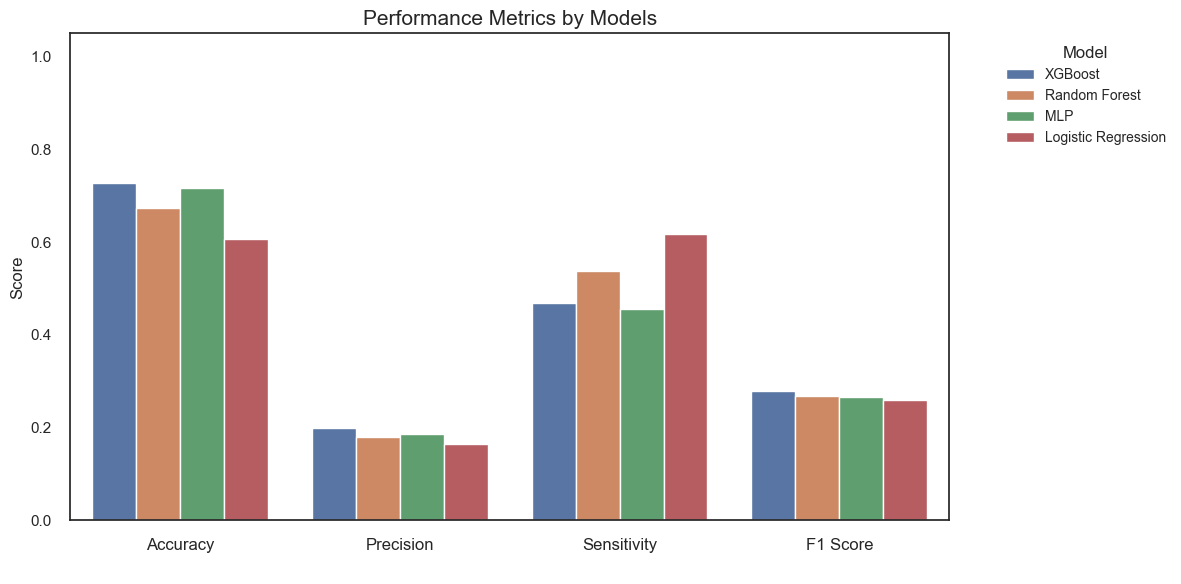

In [201]:
plot_metrics(evaluation_results_all, metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity', 'F1 Score'], models_to_plot = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP'])

## 3. Feature Selection

Here we select top 5, 10, 15, 20, 40 most important feature from feature importance and train the XGBoost model

In [ ]:
results = []

for k in [5, 10, 15, 20, 40]:
    top_feature_xgb = importance_df_XGB.sort_values(by='Importance', ascending=False).head(k)
    top_feature_names = top_feature_xgb.index.tolist()
    
    X_train_top = X_train[top_feature_names]
    X_val_top = X_val[top_feature_names]
    
    best_xgb_k, xgb_metrics_k, _ = fn.train_xgboost_model(
        X_train_top,
        y_train,
        X_val_top,
        y_val,
        fn.evaluate_model,
        model_name=f"XGBoost (Top {k} Features)"
    )
    
    xgb_metrics_k['Num Features'] = k
    
    results.append(xgb_metrics_k)

performance_df = pd.DataFrame(results)

In [122]:
performance_df

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,AUROC,AUPRC,Threshold,Best Params,Num Features
0,XGBoost (Top 5 Features),0.776358,0.210748,0.361667,0.828780,0.266312,0.642169,0.195337,0.534646,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",5
1,XGBoost (Top 10 Features),0.764574,0.210773,0.400000,0.810661,0.276074,0.650949,0.211718,0.574242,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",10
2,XGBoost (Top 15 Features),0.721367,0.194971,0.473889,0.752651,0.276275,0.657945,0.216322,0.544545,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",15
3,XGBoost (Top 20 Features),0.718935,0.194219,0.477778,0.749421,0.276172,0.659714,0.219730,0.544545,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",20


### Final model selection:
XGBoost with 20 most important features

In [ ]:
top_feature_xgb = importance_df_XGB.sort_values(by='Importance', ascending=False).head(20).index.tolist()

X_train_top = X_train[top_feature_xgb]
X_val_top = X_val[top_feature_xgb]

    
    # Train and evaluate the model
best_xgb_20, xgb_metrics_20, _ = fn.train_xgboost_model(
        X_train_top,
        y_train,
        X_val_top,
        y_val,
        fn.evaluate_model,
        model_name=f"XGBoost (Top 20 Features)"
    )

xgb_metrics_20

{'Model': 'XGBoost (Top 20 Features)',
 'Accuracy': 0.718935095704221,
 'Precision': 0.1942186088527552,
 'Sensitivity': 0.4777777777777778,
 'Specificity': 0.7494206053795912,
 'F1 Score': 0.2761721258831085,
 'AUROC': 0.6597137556476345,
 'AUPRC': 0.21972973455957343,
 'Threshold': 0.5445454545454546,
 'Best Params': {'learning_rate': 0.05,
  'max_depth': 3,
  'n_estimators': 300,
  'subsample': 0.8}}

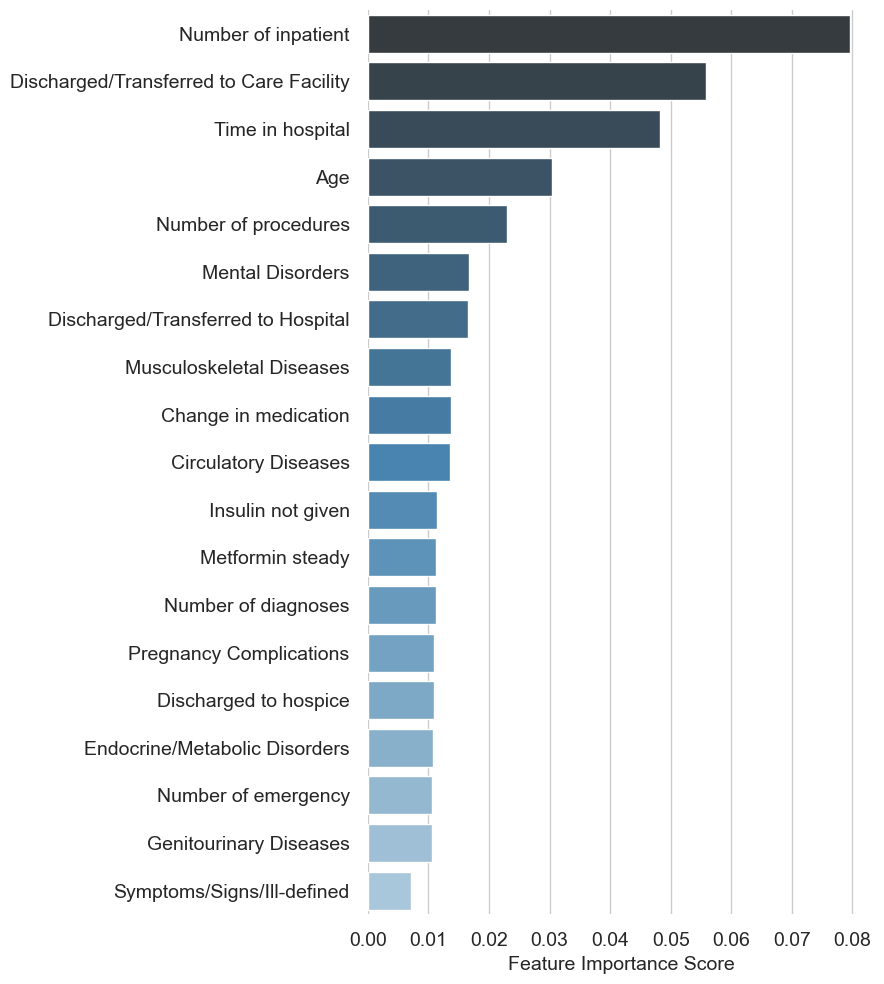

In [ ]:
# Visualize top 20 features
data = {
    'Importance': [
        0.079588, 0.055847, 0.016762, 0.016487, 0.013742, 0.01369, 0.013584,
        0.011486, 0.011336, 0.011209, 0.010928, 0.010886, 0.010767,
        0.010617, 0.010571, 0.022986, 0.030362, 0.048274, 0.007176
    ],
    'Feature': [
        'Number of inpatient', 'Discharged/Transferred to Care Facility', 'Mental Disorders',
        'Discharged/Transferred to Hospital', 'Musculoskeletal Diseases', 'Change in medication',
        'Circulatory Diseases', 'Insulin not given', 'Metformin steady', 'Number of diagnoses',
        'Pregnancy Complications', 'Discharged to hospice',
        'Endocrine/Metabolic Disorders', 'Number of emergency',
        'Genitourinary Diseases', 'Number of procedures', 'Age', 'Time in hospital',
        'Symptoms/Signs/Ill-defined'
    ]
}

df = pd.DataFrame(data).sort_values(by='Importance', ascending=False)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(9, 10))
palette = sns.color_palette("Blues_d", n_colors=len(df))[::-1]  # darker = more important

ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=df,
    palette=palette
)


plt.xlabel("Feature Importance Score", fontsize=14)
plt.ylabel("", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### ROC curve on Train Data

In [171]:
y_train_prob = best_xgb_20.predict_proba(X_train_top)[:, 1]

# run best xgb on test set
optimal_thred = xgb_metrics_20['Threshold']
y_train_prob = best_xgb_20.predict(X_train_top)
y_pred_train_proba = best_xgb_20.predict_proba(X_train_top)[:, 1]


# Apply the optimal threshold
y_pred_train = np.where(y_pred_train_proba >= optimal_thred, 1, 0)

auc_train = roc_auc_score(y_train, y_train_prob)


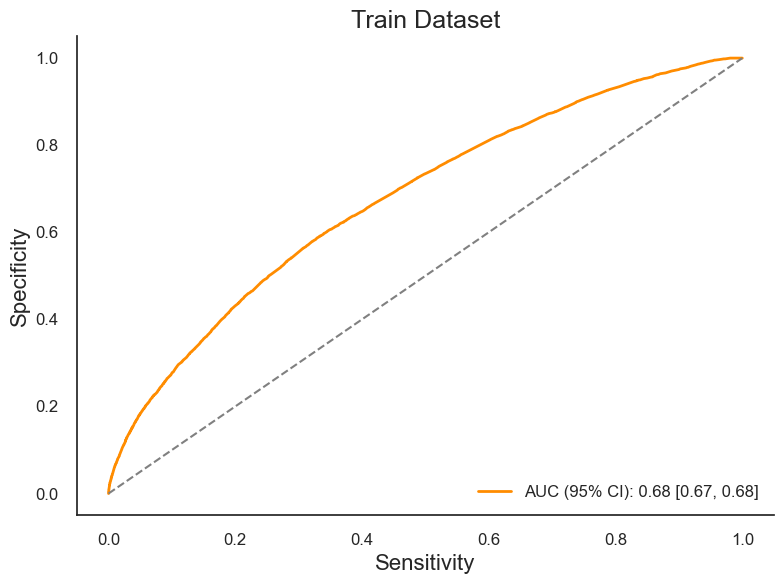

In [ ]:
# Plot a AUC curve on train & test set
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train_proba)
auc_train = roc_auc_score(y_train, y_pred_train_proba)

def bootstrap_auc_ci(y_true, y_prob, n_bootstraps=1000, ci=0.95, seed=42):
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    return lower, upper

ci_lower, ci_upper = bootstrap_auc_ci(np.array(y_train), np.array(y_pred_train_proba))

sns.set_style("white")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC (95% CI): {auc_train:.2f} [{ci_lower:.2f}, {ci_upper:.2f}]', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5)

plt.xlabel('Sensitivity', fontsize=16)
plt.ylabel('Specificity', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Train Dataset', fontsize = 18)
sns.despine()  # Remove top/right border
plt.tight_layout()
plt.show()

## Final Model Test on Test Data

### Best XGBoost based on F1 score

In [154]:
best_xgb_20

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
X_test_filtered = X_test[top_feature_xgb]

optimal_thred = xgb_metrics_20['Threshold']
y_pred_test = best_xgb_20.predict(X_test_filtered)
y_pred_test_proba = best_xgb_20.predict_proba(X_test_filtered)[:, 1]


y_pred_test = np.where(y_pred_test_proba >= optimal_thred, 1, 0)

# Evaluate the model on the test set
evaluation_results = fn.evaluate_model(y_test, y_pred_test, y_pred_test_proba, name = "XGBoost on Test Set")
evaluation_results

{'Model': 'XGBoost on Test Set',
 'Accuracy': 0.7200857898149534,
 'Precision': 0.19558131111915972,
 'Sensitivity': 0.48,
 'Specificity': 0.7504354177200966,
 'F1 Score': 0.27792074112197634,
 'AUROC': 0.6706085235749824,
 'AUPRC': 0.2327050352392809}

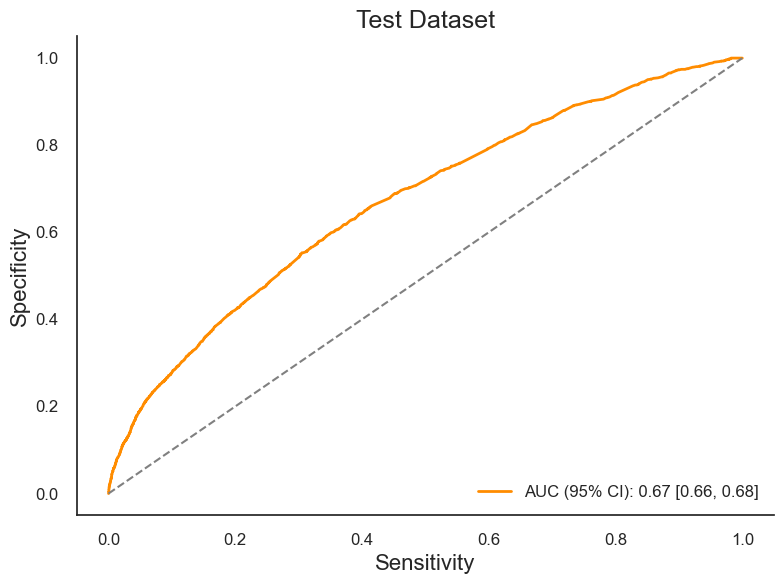

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)
auc_score = roc_auc_score(y_test, y_pred_test_proba)

def bootstrap_auc_ci(y_true, y_prob, n_bootstraps=1000, ci=0.95, seed=42):
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)
    return lower, upper

# Get CI
ci_lower, ci_upper = bootstrap_auc_ci(np.array(y_test), np.array(y_pred_test_proba))

sns.set_style("white")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC (95% CI): {auc_score:.2f} [{ci_lower:.2f}, {ci_upper:.2f}]', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5)

plt.xlabel('Sensitivity', fontsize=16)
plt.ylabel('Specificity', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Test Dataset', fontsize = 18)
sns.despine()  # Remove top/right border
plt.tight_layout()
plt.show()

